In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from dask import bag
from dask.diagnostics import ProgressBar

from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam

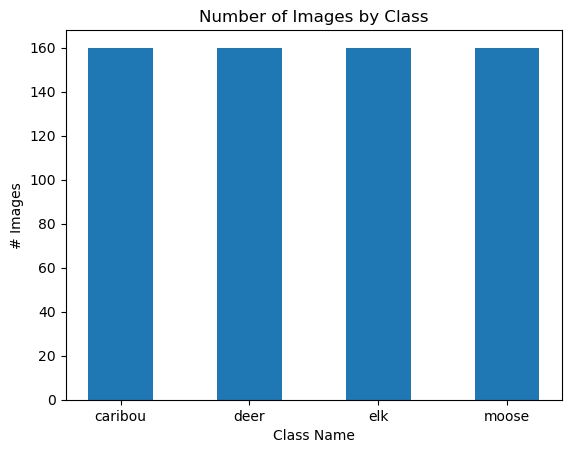

In [5]:
number_classes = {'caribou': len(os.listdir('dataset/train/caribou/')),
'deer': len(os.listdir('dataset/train/deer/')),
'elk': len(os.listdir('dataset/train/elk/')),
'moose': len(os.listdir('dataset/train/moose/'))}

plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

[########################################] | 100% Completed | 2.35 ss


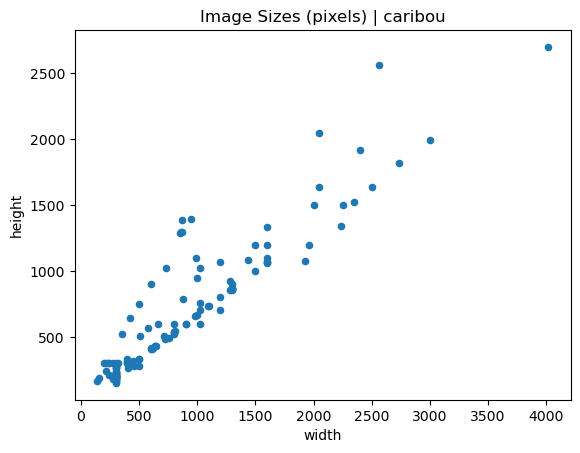

[########################################] | 100% Completed | 3.00 ss


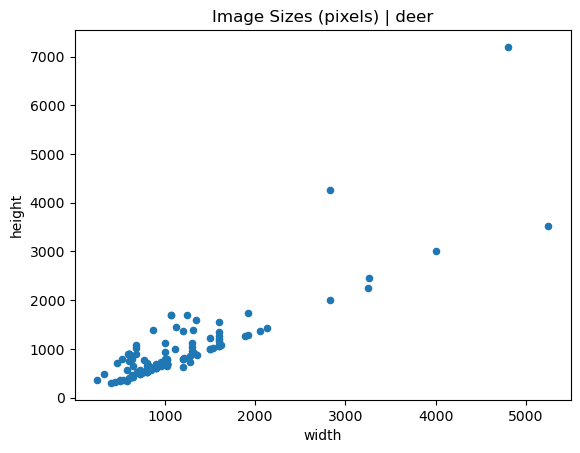

[########################################] | 100% Completed | 2.71 ss


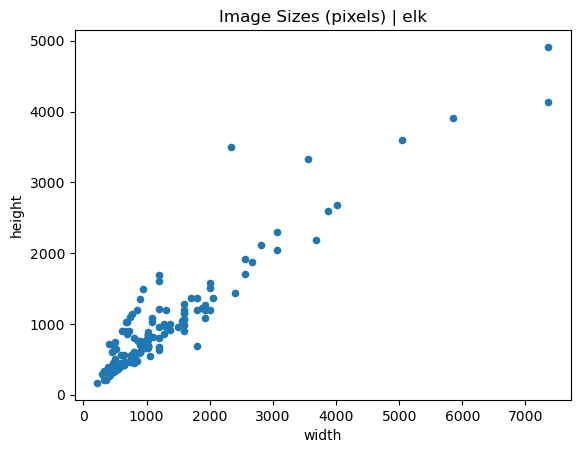

[########################################] | 100% Completed | 2.89 ss


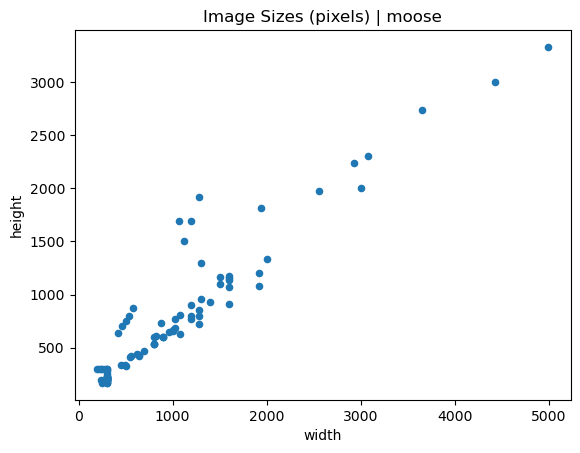

In [6]:
directories = {'caribou': 'dataset/train/caribou/',
'deer': 'dataset/train/deer/',
'elk': 'dataset/train/elk/',
'moose': 'dataset/train/moose/'}

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if len(arr.shape) == 3:  # RGB image
        h, w, d = arr.shape
    elif len(arr.shape) == 2:  # Grayscale image
        h, w = arr.shape
        d = 1  # Depth is 1 for grayscale
    else:
        raise ValueError("Unexpected image dimensions: {}".format(arr.shape))
    return h, w

for n, d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)

    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height')
        plt.title('Image Sizes (pixels) | {}'.format(n))
        plt.show()

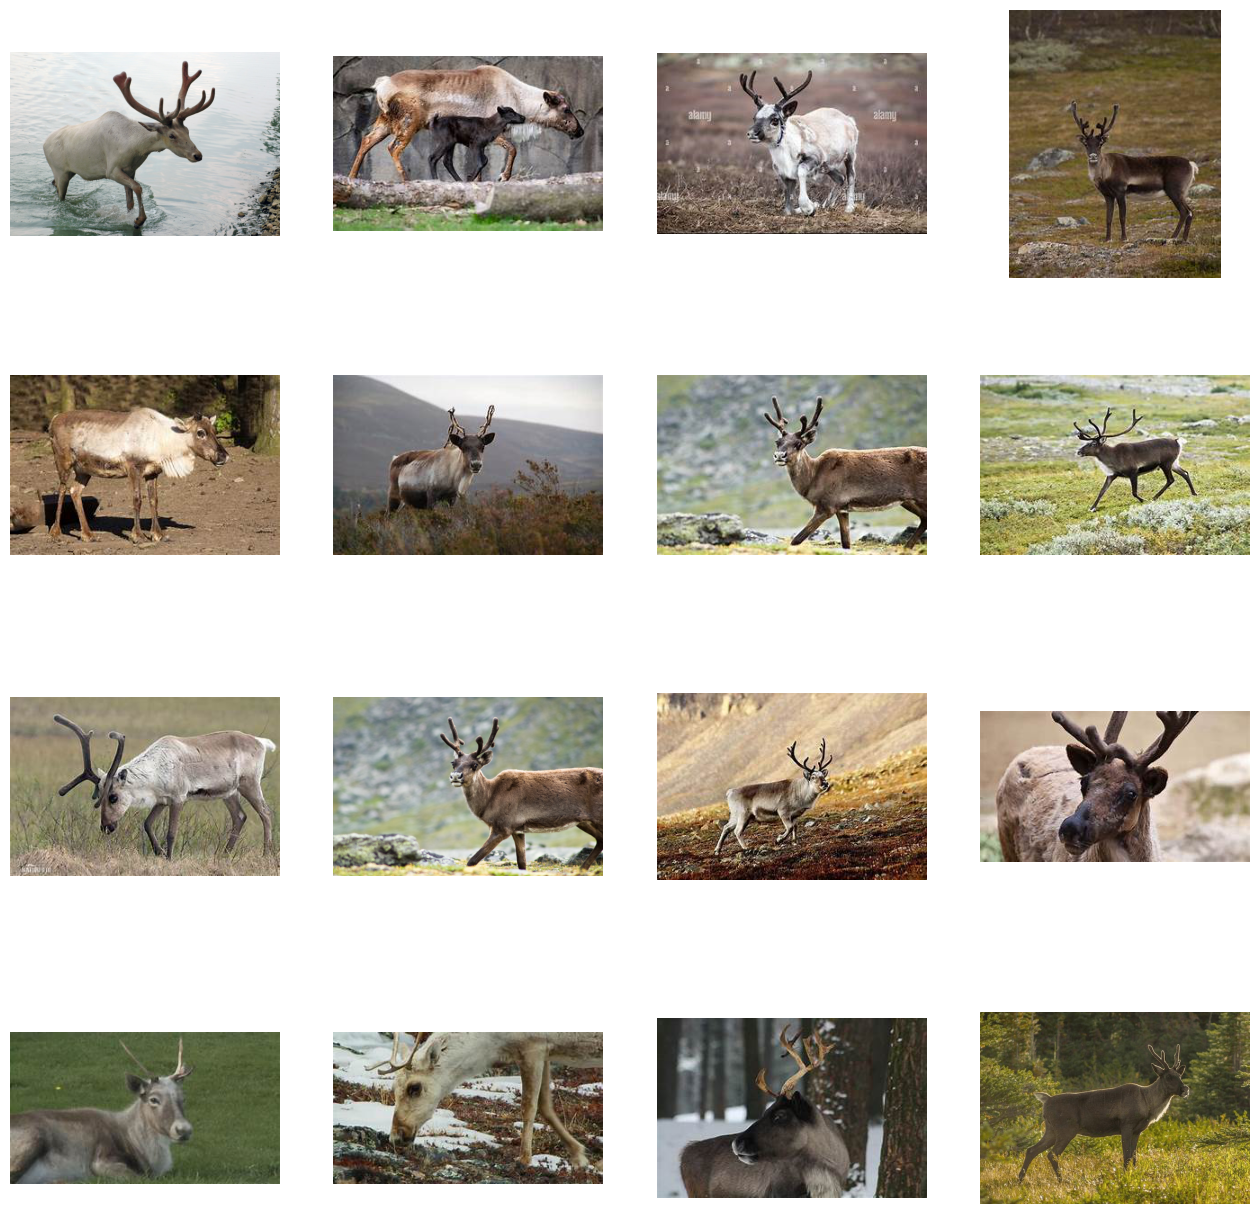

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directories = {
    'caribou': 'dataset/train/caribou/',
    'deer': 'dataset/train/deer/',
    'elk': 'dataset/train/elk/',
    'moose': 'dataset/train/moose/'
}

# Choose one directory (e.g., 'caribou') to display images from
chosen_dir = directories['caribou']
image_files = [os.path.join(chosen_dir, fname) for fname in os.listdir(chosen_dir)]
# Ensure there are images in the directory
if not image_files:
    print(f"No images found in {chosen_dir}")
    exit()

# Show images displayed 4x4
nrows = 4
ncols = 4

def show_image_sample(pic_directory):
    # display 4x4 images
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i, img_path in enumerate(pic_directory[:16]):  # Limiting to 16 images for 4x4 display
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

# Now, display images from the chosen directory
show_image_sample(image_files)

In [8]:
def get_image_type(image_path):
    """
    Determine if an image is 'grayscale' or 'rgb'.
    """
    im = Image.open(image_path)
    arr = np.array(im)
    if len(arr.shape) == 2:
        return 'grayscale'
    elif len(arr.shape) == 3 and arr.shape[2] == 3:
        return 'rgb'
    else:
        return 'other'  # Might catch cases like RGBA or other unexpected formats.

def count_image_types(directory_path):
    """
    Count the number of 'grayscale' and 'rgb' images in a directory.
    """
    grayscale_count = 0
    rgb_count = 0

    for fname in os.listdir(directory_path):
        image_path = os.path.join(directory_path, fname)
        img_type = get_image_type(image_path)
        if img_type == 'grayscale':
            grayscale_count += 1
        elif img_type == 'rgb':
            rgb_count += 1

    return grayscale_count, rgb_count

directories = {
    'caribou': 'dataset/train/caribou/',
    'deer': 'dataset/train/deer/',
    'elk': 'dataset/train/elk/',
    'moose': 'dataset/train/moose/'
}

# Loop through each directory and count image types
for animal, dir_path in directories.items():
    grayscale_count, rgb_count = count_image_types(dir_path)
    print(f"For {animal}:")
    print(f"Number of grayscale images: {grayscale_count}")
    print(f"Number of RGB images: {rgb_count}")
    print("-" * 50)


For caribou:
Number of grayscale images: 2
Number of RGB images: 158
--------------------------------------------------
For deer:
Number of grayscale images: 0
Number of RGB images: 160
--------------------------------------------------
For elk:
Number of grayscale images: 0
Number of RGB images: 160
--------------------------------------------------
For moose:
Number of grayscale images: 0
Number of RGB images: 160
--------------------------------------------------


In [9]:
def get_image_type(image_path):
    """
    Determine if an image is 'grayscale' or 'rgb'.
    """
    im = Image.open(image_path)
    arr = np.array(im)
    if len(arr.shape) == 2:
        return 'grayscale'
    elif len(arr.shape) == 3 and arr.shape[2] == 3:
        return 'rgb'
    else:
        return 'other'  # Might catch cases like RGBA or other unexpected formats.

def count_image_types_and_get_grayscale_filenames(directory_path):
    """
    Count the number of 'grayscale' and 'rgb' images in a directory and
    return filenames of 'grayscale' images.
    """
    grayscale_count = 0
    rgb_count = 0
    grayscale_filenames = []

    for fname in os.listdir(directory_path):
        image_path = os.path.join(directory_path, fname)
        img_type = get_image_type(image_path)
        if img_type == 'grayscale':
            grayscale_count += 1
            grayscale_filenames.append(fname)
        elif img_type == 'rgb':
            rgb_count += 1

    return grayscale_count, rgb_count, grayscale_filenames

# Loop through each directory and count image types
for animal, dir_path in directories.items():
    grayscale_count, rgb_count, grayscale_files = count_image_types_and_get_grayscale_filenames(dir_path)
    print(f"For {animal}:")
    print(f"Number of grayscale images: {grayscale_count}")
    print(f"Number of RGB images: {rgb_count}")
    print(f"Filenames of grayscale images: {grayscale_files}")
    print("-" * 50)


For caribou:
Number of grayscale images: 2
Number of RGB images: 158
Filenames of grayscale images: ['Female_Caribou26.png', 'Male_Caribou54.png']
--------------------------------------------------
For deer:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------
For elk:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------
For moose:
Number of grayscale images: 0
Number of RGB images: 160
Filenames of grayscale images: []
--------------------------------------------------


In [12]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

PATH = 'dataset/train/'

train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


In [13]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [14]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  seed=123,
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


In [15]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [16]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [17]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

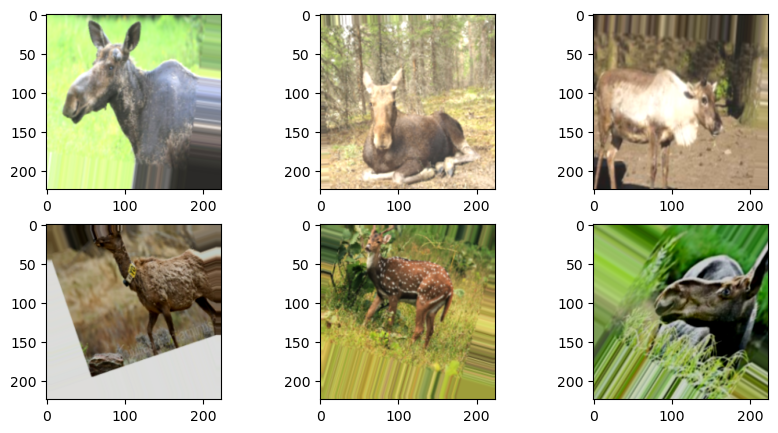

In [18]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [19]:
full_train_ds = train_ds.concatenate(augmented_train)

In [20]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

1152


In [25]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [85]:
# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(input_shape=(224,224,3), 
                         include_top=False,
                         pooling='max',
                         weights="imagenet")
model_vgg16.trainable = False

# display the summary to see the properties of the model
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [123]:
#Set new output
vgg16_output = model_vgg16.output

x = tf.keras.layers.Flatten()(vgg16_output)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=model_vgg16.inputs, outputs=new_outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [124]:
#Check Trainable
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False
Layer 19: name = global_max_pooling2d , trainable = False
Layer 20: na

In [125]:
# Defining Callbacks

checkpoint_filepath = "vgg16_callback/model_epoch{epoch:02d}_valloss{val_loss:.2f}.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                option = tf.saved_model.SaveOptions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)
callback_list = [earlystopping, checkpoint,reduce_lr]

In [126]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [128]:
epoch = 30
model_history=model.fit(train_dataset,
                        validation_data=val_ds,
                        epochs = epoch,
                        callbacks = callback_list,
                        verbose = 2)

Epoch 1/5


KeyboardInterrupt: 

In [38]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

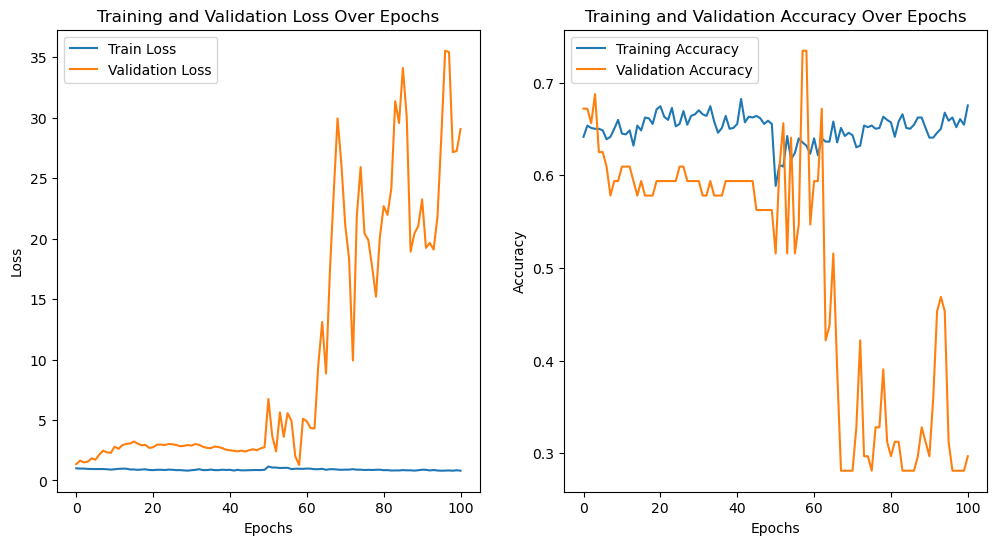

In [116]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [41]:
start_tune = 15
stop_tune = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_vgg16.layers[start_tune:stop_tune]:
  layer.trainable = True

for layer in model_vgg16.layers:
  if layer.__class__.__name__ in ["BatchNormalization"]:
    layer.trainable = False

# Model Compile 
lr = 0.0001
# OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_3 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = True
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = False
Layer 19: name = global_max_pooling2d , trainable = False
Layer 20: name 

In [42]:
fine_tune_epochs = 50
total_epochs =  epoch + fine_tune_epochs
model_history_2nd = model.fit(train_dataset,
                        validation_data=val_ds,
                        epochs = total_epochs,
                        initial_epoch=model_history.epoch[-1],
                        callbacks = callback_list,
                        verbose = 2)

Epoch 50/100

Epoch 50: val_loss did not improve from 1.35047
36/36 - 196s - loss: 1.1559 - accuracy: 0.5885 - val_loss: 6.7434 - val_accuracy: 0.5156 - lr: 1.0000e-04 - 196s/epoch - 5s/step
Epoch 51/100

Epoch 51: val_loss did not improve from 1.35047
36/36 - 195s - loss: 1.0713 - accuracy: 0.6111 - val_loss: 3.6909 - val_accuracy: 0.6094 - lr: 1.0000e-04 - 195s/epoch - 5s/step
Epoch 52/100

Epoch 52: val_loss did not improve from 1.35047
36/36 - 193s - loss: 1.0693 - accuracy: 0.6094 - val_loss: 2.4003 - val_accuracy: 0.6562 - lr: 1.0000e-04 - 193s/epoch - 5s/step
Epoch 53/100

Epoch 53: val_loss did not improve from 1.35047
36/36 - 191s - loss: 1.0316 - accuracy: 0.6424 - val_loss: 5.6289 - val_accuracy: 0.5156 - lr: 1.0000e-04 - 191s/epoch - 5s/step
Epoch 54/100

Epoch 54: val_loss did not improve from 1.35047
36/36 - 192s - loss: 1.0423 - accuracy: 0.6172 - val_loss: 3.6074 - val_accuracy: 0.6406 - lr: 1.0000e-04 - 192s/epoch - 5s/step
Epoch 55/100

Epoch 55: val_loss did not impr

In [43]:
train_acc += model_history_2nd.history['accuracy']
val_acc += model_history_2nd.history['val_accuracy']

train_loss += model_history_2nd.history['loss']
val_loss += model_history_2nd.history['val_loss']

Text(0, 0.5, 'Accuracy')

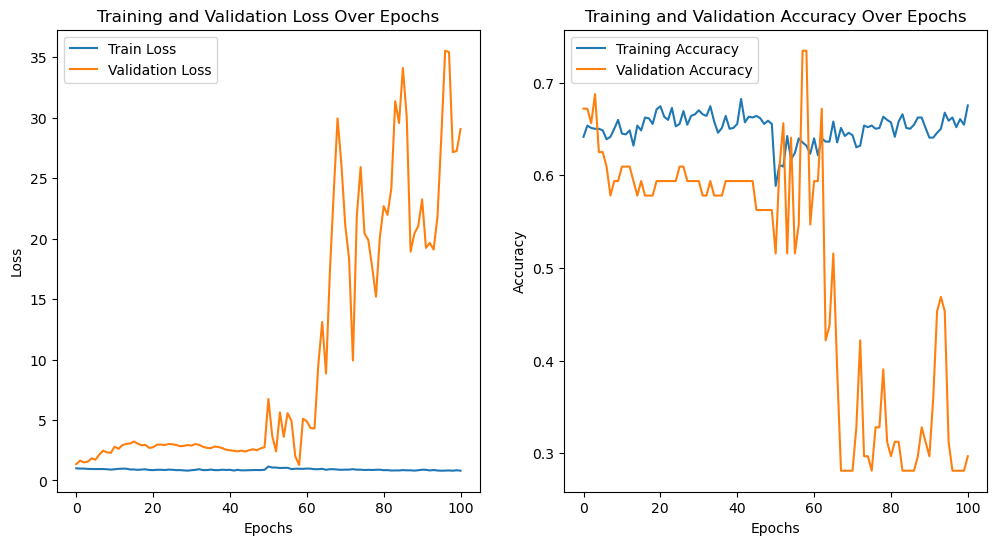

In [115]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [74]:
import tensorflow.keras.applications
from tensorflow.keras.preprocessing import image
import numpy as np

model_resnet = tensorflow.keras.applications.ResNet152V2(weights='imagenet')
model_vgg = tensorflow.keras.applications.VGG16(weights='imagenet')
model_incept = tensorflow.keras.applications.InceptionV3(weights='imagenet')
model_dense = tensorflow.keras.applications.DenseNet201(weights='imagenet')

img_path = 'dataset/test/deer/roe_deer_1.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

img_incept = image.load_img(img_path, target_size=(299, 299))
x_incept = image.img_to_array(img_incept)
x_incept = np.expand_dims(x_incept, axis=0)

x_resnet = tensorflow.keras.applications.resnet_v2.preprocess_input(x)
x_vgg = tensorflow.keras.applications.vgg16.preprocess_input(x)
x_incept = tensorflow.keras.applications.inception_v3.preprocess_input(x_incept)
x_dense = tensorflow.keras.applications.densenet.preprocess_input(x)

preds_resnet = model_resnet.predict(x_resnet)
preds_vgg = model_vgg.predict(x_vgg)
preds_incept = model_incept.predict(x_incept)
preds_dense = model_dense.predict(x_dense)
print('\nPredicted Resnet152V2:\n', tensorflow.keras.applications.resnet_v2.decode_predictions(preds_resnet, top=3)[0])
print('\nPredicted VGG16:\n', tensorflow.keras.applications.vgg16.decode_predictions(preds_vgg, top=3)[0])
print('\nPredicted Inception_V3:\n', tensorflow.keras.applications.inception_v3.decode_predictions(preds_incept, top=3)[0])
print('\nPredicted DenseNet201:\n', tensorflow.keras.applications.densenet.decode_predictions(preds_dense, top=3)[0])

1/1 [==============================] - 5s 5s/step

Predicted Resnet152V2:
 [('n02841315', 'binoculars', 1.0), ('n03602883', 'joystick', 6.730016e-16), ('n07836838', 'chocolate_sauce', 9.780162e-25)]

Predicted VGG16:
 [('n03788365', 'mosquito_net', 0.017499257), ('n03291819', 'envelope', 0.0153658325), ('n15075141', 'toilet_tissue', 0.0115129035)]

Predicted Inception_V3:
 [('n02422699', 'impala', 0.52635556), ('n02423022', 'gazelle', 0.29765448), ('n02417914', 'ibex', 0.058847103)]

Predicted DenseNet201:
 [('n03729826', 'matchstick', 0.1580327), ('n04286575', 'spotlight', 0.0926795), ('n03666591', 'lighter', 0.049945846)]


In [88]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

input_2 [(None, 224, 224, 3)]
block1_conv1 (None, 224, 224, 64)
block1_conv2 (None, 224, 224, 64)
block1_pool (None, 112, 112, 64)
block2_conv1 (None, 112, 112, 128)
block2_conv2 (None, 112, 112, 128)
block2_pool (None, 56, 56, 128)
block3_conv1 (None, 56, 56, 256)
block3_conv2 (None, 56, 56, 256)
block3_conv3 (None, 56, 56, 256)
block3_pool (None, 28, 28, 256)
block4_conv1 (None, 28, 28, 512)
block4_conv2 (None, 28, 28, 512)
block4_conv3 (None, 28, 28, 512)
block4_pool (None, 14, 14, 512)
block5_conv1 (None, 14, 14, 512)
block5_conv2 (None, 14, 14, 512)
block5_conv3 (None, 14, 14, 512)
block5_pool (None, 7, 7, 512)
global_max_pooling2d (None, 512)
flatten_2 (None, 512)
dense_4 (None, 1024)
batch_normalization_2 (None, 1024)
dense_5 (None, 512)
batch_normalization_3 (None, 512)
dropout_1 (None, 512)
dense_6 (None, 4)


In [89]:
model_path = "vgg16_callback/model_epoch58_valloss1.27.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_ds)
print(f'{loaded_model.metrics_names}: {results}')

5/5 [==============================] - 19s 4s/step - loss: 2.1641 - accuracy: 0.7375
['loss', 'accuracy']: [2.1640520095825195, 0.737500011920929]


In [102]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image, label in test_ds:
   # append true labels
   y_true.append(label)
   # compute predictions
   preds = loaded_model.predict(image)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 8s 8s/step


Text(0.5, 1.0, 'VGG16')

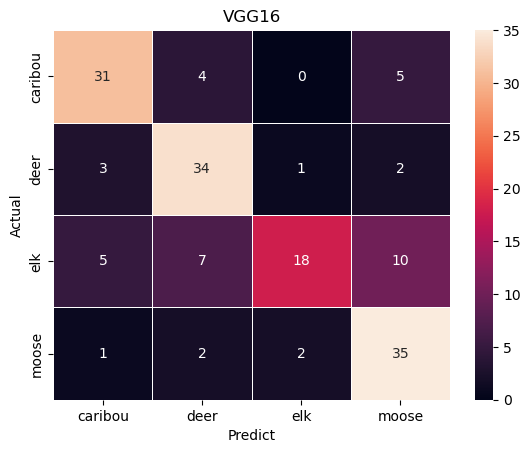

In [109]:
import seaborn as sns

label = ['caribou','deer','elk','moose']
cm = confusion_matrix(correct_labels, predicted_labels)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')
plt.title('VGG16')

Text(0.5, 1.0, 'VGG16')

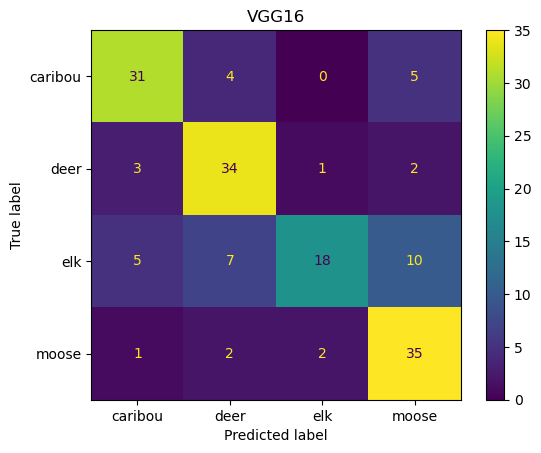

In [117]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels,display_labels=label)
plt.title('VGG16')

In [111]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        40
           1       0.72      0.85      0.78        40
           2       0.86      0.45      0.59        40
           3       0.67      0.88      0.76        40

    accuracy                           0.74       160
   macro avg       0.76      0.74      0.73       160
weighted avg       0.76      0.74      0.73       160



In [106]:
last_conv_layer_name = "block5_conv3"

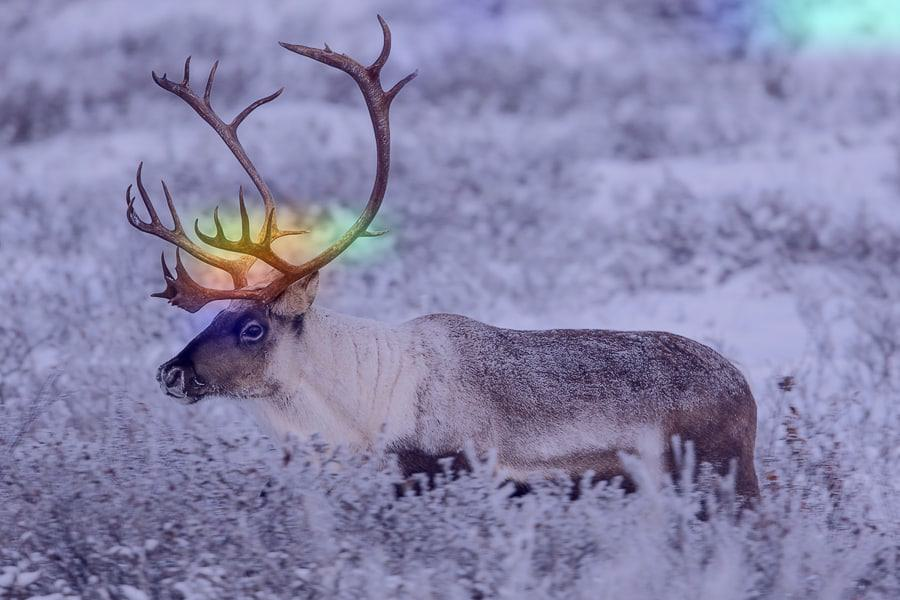

In [107]:
grad_cam_img_path = 'dataset/test/caribou/Male_Caribou8.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

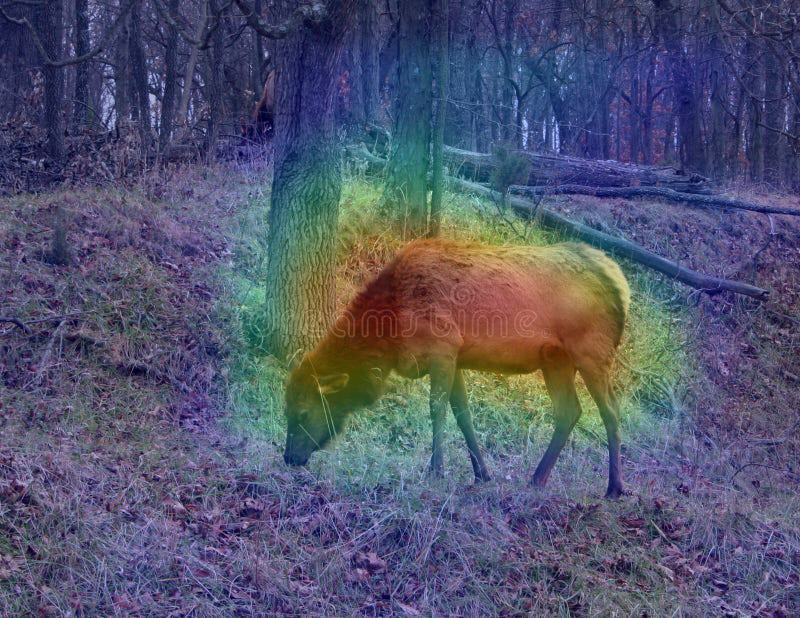

In [97]:
grad_cam_img_path = 'dataset/test/elk/EDF91.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

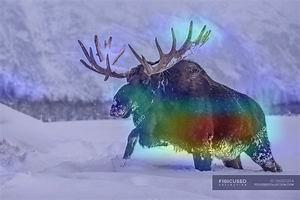

In [98]:
grad_cam_img_path = 'dataset/test/moose/male_moose (86).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

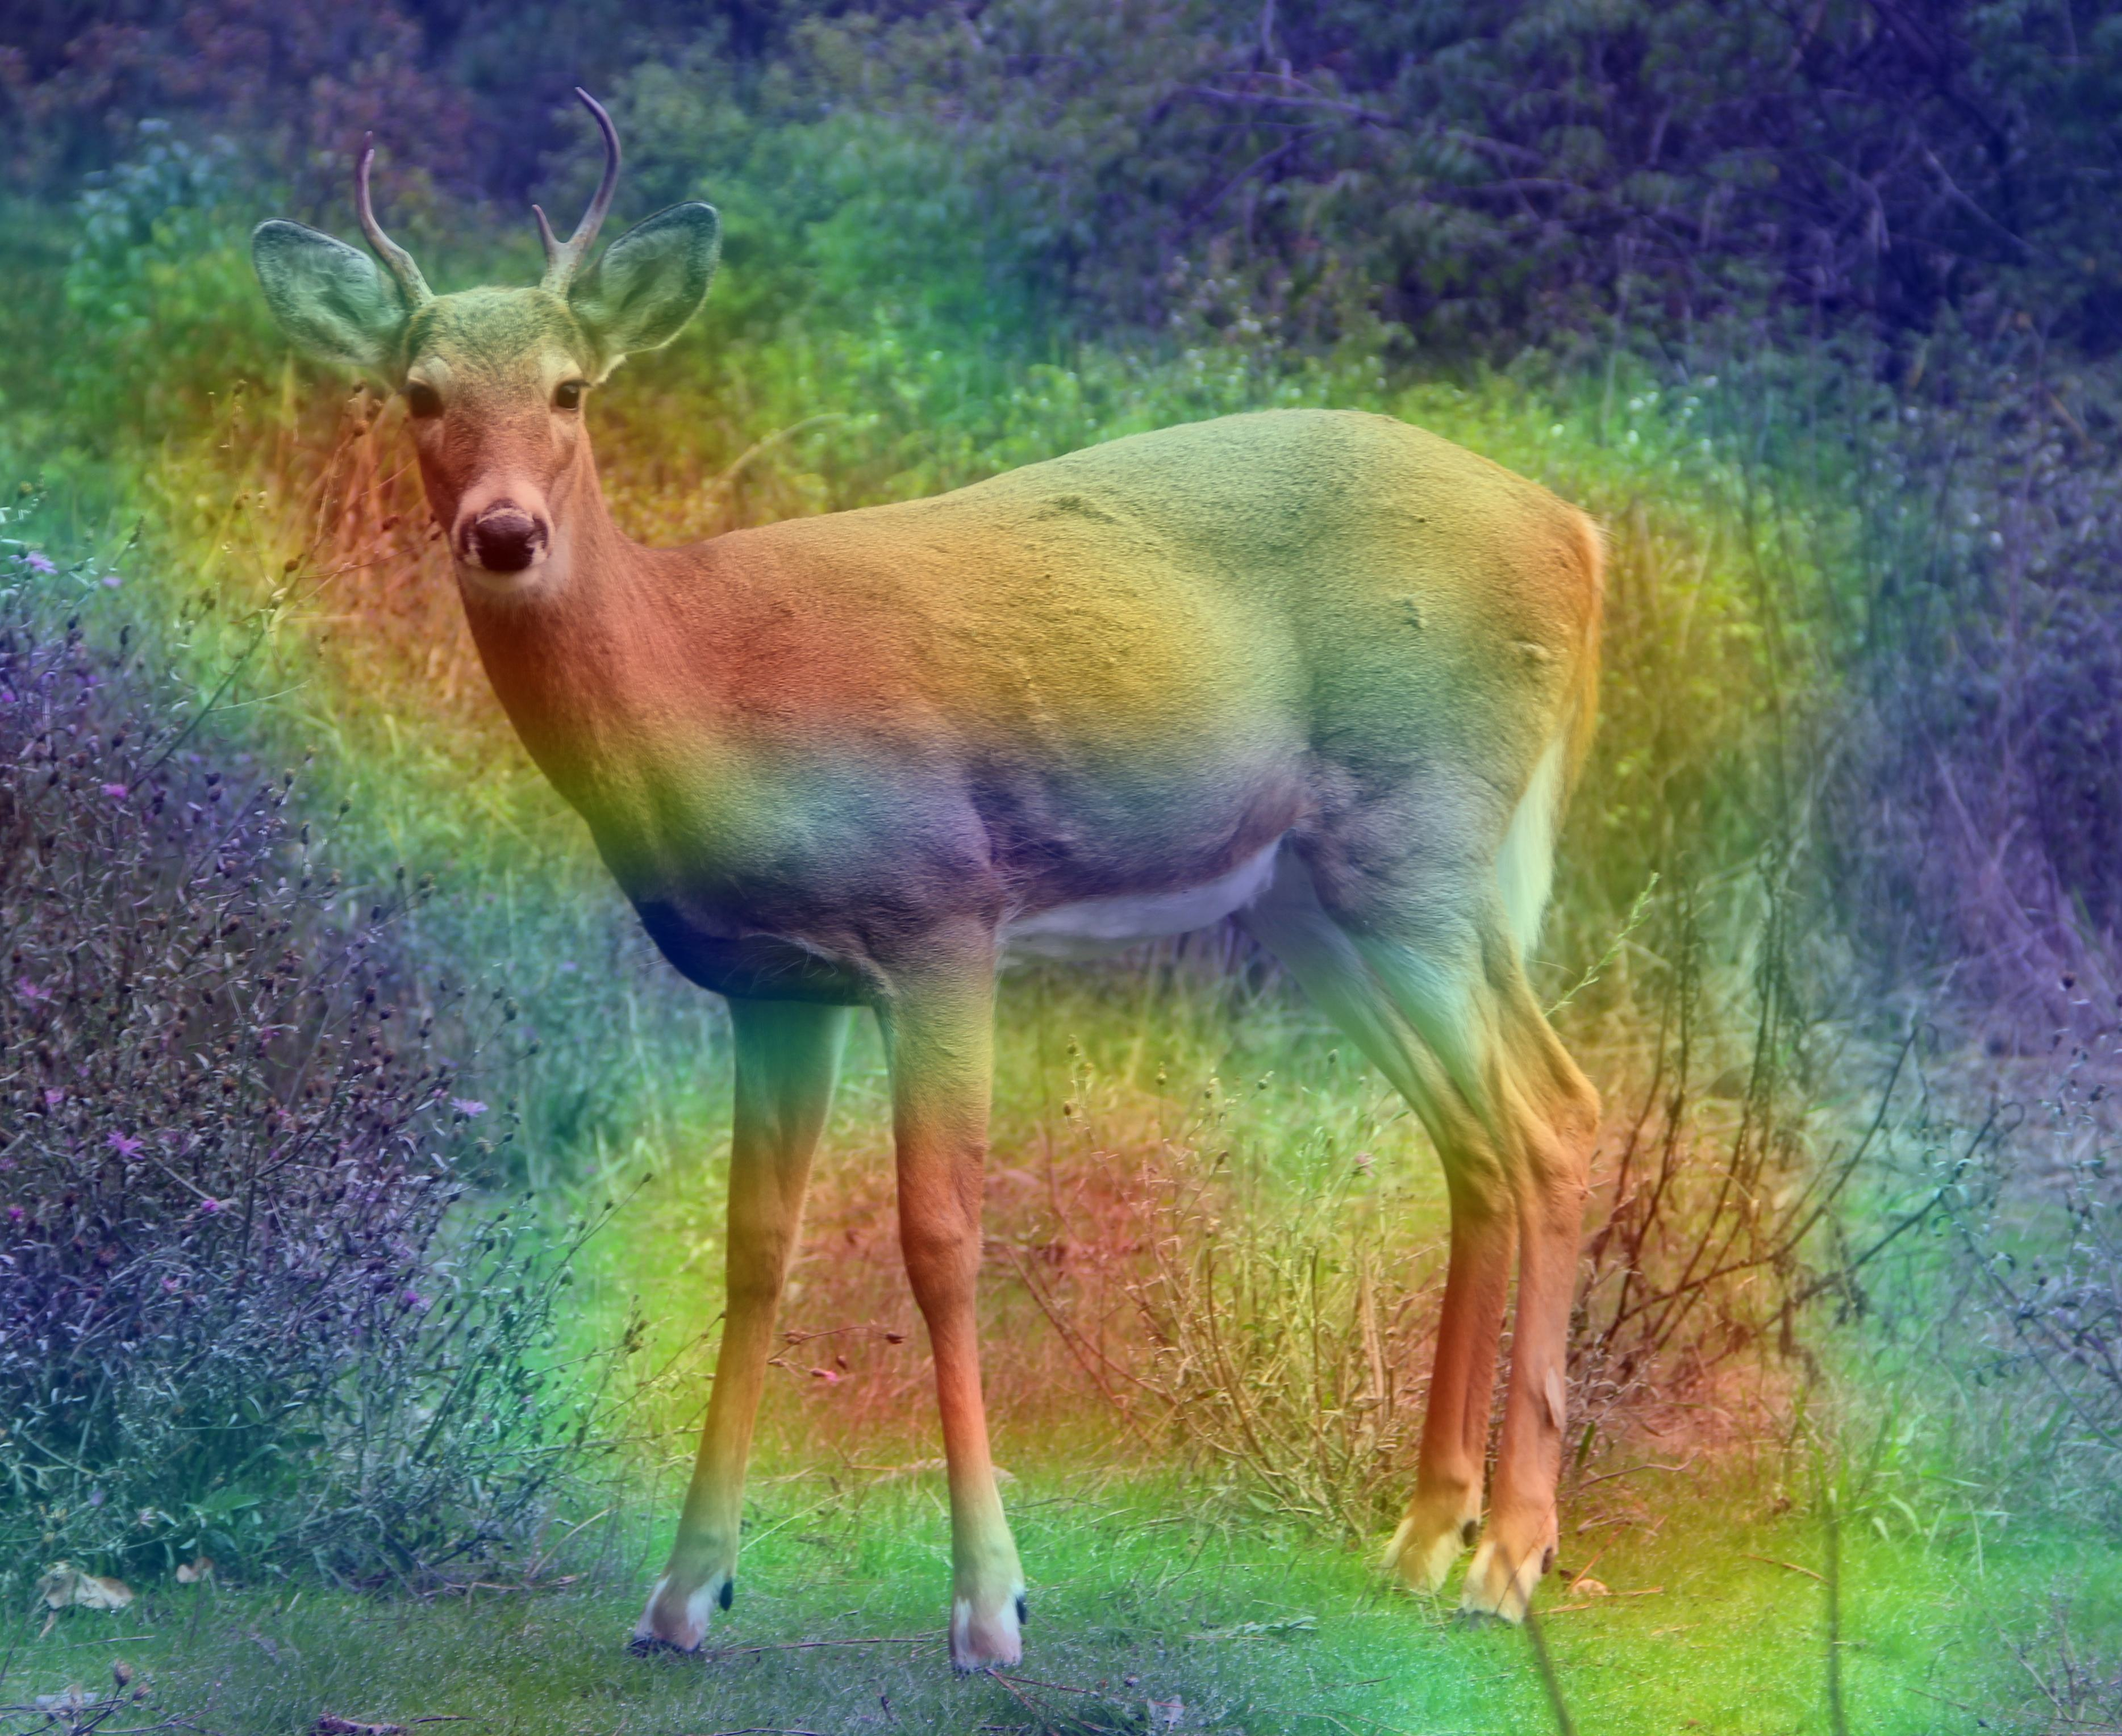

In [95]:
grad_cam_img_path = 'dataset/test/deer/white_tailed_deer_00019.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(img, loaded_model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

1/1 [==============================] - 0s 187ms/step


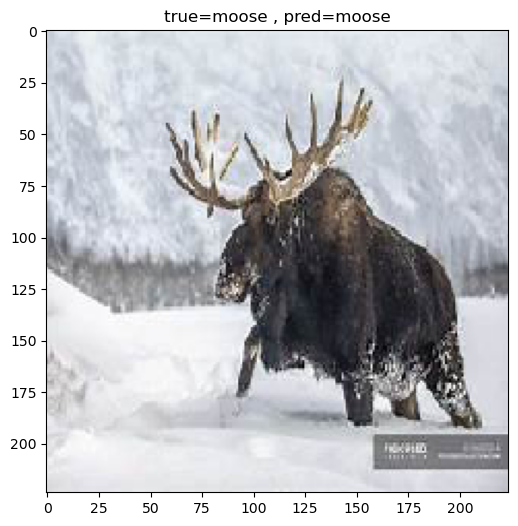

In [129]:
"""
dataset/test/caribou/Male_Caribou8.jpg
dataset/test/elk/EDF91.jpg
dataset/test/moose/male_moose (86).jpg
dataset/test/deer/white_tailed_deer_00019.jpg
"""
img_path = 'dataset/test/moose/male_moose (86).jpg'

label_dict = {0:"caribou",1:"deer",2:"elk",3:"moose"}
y_true = img_path.split("/")

img = tf.keras.utils.load_img(img_path, target_size=(224,224))
array = tf.keras.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)
x = preprocess_input(array)

preds = loaded_model.predict(x)
y_pred = np.argmax(preds)

plt.figure( figsize=(12,6))
ax = plt.gca()
plt.imshow(img)
plt.title( f"true={y_true[2]} , pred={label_dict[y_pred]}" )
plt.show()